In [61]:
# Imports
import sys
import os
import time
import math
import random

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Plotting import
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import the utils for plotting the metrics
from plot_utils import plot_utils
from plot_utils import notebook_utils_2

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [62]:
# Fix the colour scheme for each particle type
color_dict = {"gamma":"red", "e":"blue", "mu":"green"}

# Fix the numpy seed
np.random.seed(42)

In [63]:
def plot_log(dump_dirs, model_ids, model_cls, keys, lgd_loc=(0.8,0.5), val=False, log=False, show=False, save_path=None):
    """Generic method for plotting the logs for any model
    
    Args:
    dump_dirs -- Dumps directories for each run
    model_ids -- Names of the models for which the log is being plotted
    model_cls -- Two colors for each model for one axis on each size of the plot
    keys      -- Two keys for columns in the dataframe to plot
    log       -- Boolean to determine whether to use (log scaling) or not
    lgd_loc   -- Tuple to determine the location of the legend
    show      -- Boolean to determine whether to call plt.show()
    save_path -- Absolute path of the location at which to save the plot
    """
    
    # Defensive assertions to prevent Nonetype error
    assert dump_dirs is not None
    assert model_ids is not None
    assert model_cls is not None
    
    # Defensive assertion to prevent breaking function usage
    assert len(dump_dirs) == len(model_ids)
    assert len(model_ids) == len(model_cls)
    assert len(keys) == 2
    
    # Extract the values stored in the .csv files
    train_epochs = []
    val_epochs = []
    
    train_0 = []
    train_1 = []
    
    val_0 = []
    val_1 = []
    
    dump_dirs = ["/home/akajal/WatChMaL/VAE/dumps/" + dump_dir + "/" for dump_dir in dump_dirs]
    
    # Iterate over the logs for all the models
    for dump_dir in dump_dirs:
        
        train_log_path = dump_dir + "log_train.csv"
        val_log_path = dump_dir + "log_val.csv"
        
        if os.path.exists(train_log_path) and os.path.exists(val_log_path):
            train_log_df = pd.read_csv(train_log_path, usecols=["epoch",keys[0],keys[1]])
            if val:
                val_log_df = pd.read_csv(val_log_path, usecols=["epoch",keys[0],keys[1]])
            
        train_epochs.append(train_log_df["epoch"].values)
        train_0.append(train_log_df[keys[0]].values)
        train_1.append(train_log_df[keys[1]].values)
        
        if val:
            val_epochs.append(val_log_df["epoch"].values)
            val_0.append(val_log_df[keys[0]].values)
            val_1.append(val_log_df[keys[1]].values)
     
    # Initialize the plot
    fig, ax1 = plt.subplots(figsize=(16,11))
    ax2 = ax1.twinx()
    
    # Print the mpl rcParams
    mpl.rcParams['agg.path.chunksize']=1e12
    
    # Reload the backend
    mpl.use(mpl.get_backend())
    
    for i, model_ids in enumerate(model_ids):
        if val:
            ax1.plot(train_epochs[i], train_0[i], color=model_cls[i][0], alpha=0.3, linewidth=1.0)
            ax2.plot(train_epochs[i], train_1[i], color=model_cls[i][1], alpha=0.3, linewidth=1.0)
            
            ax1.plot(val_epochs[i], val_0[i], color=model_cls[i][0], label=model_ids+" "+keys[0], alpha=1.0,
                     linewidth=1.0)
            ax2.plot(val_epochs[i], val_1[i], color=model_cls[i][1], label=model_ids+" "+keys[1], alpha=1.0,
                     linewidth=1.0)
        else:
            ax1.plot(train_epochs[i], train_0[i], color=model_cls[i][0], label=model_ids+" "+keys[0],
                     alpha=0.3, linewidth=1.0)
            ax2.plot(train_epochs[i], train_1[i], color=model_cls[i][1], label=model_ids+" "+keys[1],
                     alpha=0.3, linewidth=1.0)
    
    if log:
        ax1.set_yscale("log")
        ax2.set_yscale("log")
    
    # Setup plot characteristics
    ax1.tick_params(axis="x", labelsize=30)
    ax1.set_xlabel("Epoch", fontsize=30)
    
    ax1.set_ylabel(keys[0], fontsize=30, color=model_colors[0][0])
    ax1.tick_params(axis="y", labelsize=30, color=model_colors[0][0])
    
    ax2.set_ylabel(keys[1], fontsize=30, color=model_colors[0][1])
    ax2.tick_params(axis="y", labelsize=30, color=model_colors[0][1])
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    
    lgd = plt.legend(lines1 + lines2, labels1 + labels2, prop={"size":30},
                     loc="upper right", bbox_to_anchor=lgd_loc, frameon=True,
                     fancybox=True, shadow=True, framealpha=1.0)
    
    ax1.grid(True, which="both", axis="both")
    ax2.grid(True, which="both", axis="both")
    
    plt.margins(0.2)
    
    if save_path is not None:
        plt.savefig(save_path, format='pdf', dpi=600, bbox_extra_artists=(lgd))
    if show:
        try:
            plt.show()
        except:
            print("plot_log() : Unable to render the plot" 
                  + " due to limits on \'agg.path.chunksize\')")
            if save_path is None:
                print("plot_log() : Saving plot to ./{0}".format("vae_training_log.pdf"))
                plt.savefig("vae_training_log.eps", format='pdf', dpi=600, bbox_extra_artists=(lgd))
            plt.clf()
            plt.close()
    else:
        plt.clf()
        plt.close()
    

In [64]:
# Plot the ROC curve for one vs another class
def plot_old_ROC(softmaxes, labels, energies, softmax_index_dict, label_0, label_1, 
                 min_energy=0, max_energy=1500, show_plot=False, save_path=None):
    
    assert softmaxes is not None
    assert labels is not None
    assert softmax_index_dict  is not None
    assert softmaxes.shape[0] == labels.shape[0]
    assert label_0 in softmax_index_dict.keys()
    assert label_1 in softmax_index_dict.keys()
    
    #------------------------------------------------------------------------
    # Create a boolean map to select events in the user-defined energy range
    #------------------------------------------------------------------------
    
    energy_slice_map = [False for i in range(len(energies))]
    
    for i in range(len(energies)):
        if(energies[i] >= min_energy and energies[i] < max_energy):
                energy_slice_map[i] = True
                
    curr_softmax = softmaxes[energy_slice_map]
    curr_labels = labels[energy_slice_map]
    
    #------------------------------------------------------------------------
    # Extract the softmax and true label values for signal and background events
    #------------------------------------------------------------------------
    
    # Extract the useful softmax and labels from the input arrays
    softmax_0 = curr_softmax[curr_labels==softmax_index_dict[label_0]]
    labels_0 = curr_labels[curr_labels==softmax_index_dict[label_0]] 
    
    softmax_1 = curr_softmax[curr_labels==softmax_index_dict[label_1]]
    labels_1 = curr_labels[curr_labels==softmax_index_dict[label_1]]
    
    # Add the two arrays
    softmax = np.concatenate((softmax_0, softmax_1), axis=0)
    labels = np.concatenate((labels_0, labels_1), axis=0)

    #------------------------------------------------------------------------
    # Compute the ROC curve and the AUC for class corresponding to label 0
    #------------------------------------------------------------------------
    
    fpr, tpr, threshold = roc_curve(labels, softmax[:,softmax_index_dict[label_0]], pos_label=softmax_index_dict[label_0])
    roc_auc = auc(fpr, tpr)
    
    tnr = 1. - fpr
    
    if show_plot or save_path is not None:
        
        # TNR vs TPR plot
        fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
        ax.tick_params(axis="both", labelsize=20)

        ax.plot(tpr, tnr, color=color_dict[label_0],
                 label=r"$\{0}$, AUC ${1:0.3f}$".format(label_0, roc_auc) if label_0 is not "e" else r"${0}$, AUC ${1:0.3f}$".format(label_0, roc_auc),
                 linewidth=1.0, marker=".", markersize=4.0, markerfacecolor=color_dict[label_0])

        # Show coords of individual points near x = 0.2, 0.5, 0.8
        todo = {0.2: True, 0.5: True, 0.8: True}
        for xy in zip(tpr, tnr):
            xy = (round(xy[0], 3), round(xy[1], 3))
            for point in todo.keys():
                if xy[0] >= point and todo[point]:
                    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data', fontsize=18, bbox=dict(boxstyle="square", fc="w"))
                    todo[point] = False

        ax.grid(True, which='both', color='grey')
        xlabel = r"$\{0}$ signal efficiency".format(label_0) if label_0 is not "e" else r"${0}$ signal efficiency".format(label_0)
        ylabel = r"$\{0}$ background rejection".format(label_1) if label_1 is not "e" else r"${0}$ background rejection".format(label_1)

        ax.set_xlabel(xlabel, fontsize=20) 
        ax.set_ylabel(ylabel, fontsize=20)

        ax.set_title(r"${0} \leq E < {1}$".format(round(min_energy,2), round(max_energy,2)), fontsize=20)
        ax.legend(loc="upper right", prop={"size":20})
        
        plt.margins(0.1)
        
    if save_path is not None:
        plt.savefig(save_path)
    
    if show_plot:
        plt.show()
        
    plt.clf() # Clear the current figure
    plt.close() # Close the opened window
        
        
    return fpr, tpr, threshold, roc_auc

In [65]:
# Plot the ROC curve for one vs another class
def plot_new_ROC(softmaxes, labels, energies, softmax_index_dict, label_0, label_1, 
                 min_energy=0, max_energy=1500, show_plot=False, save_path=None):
    
    assert softmaxes is not None
    assert labels is not None
    assert softmax_index_dict  is not None
    assert softmaxes.shape[0] == labels.shape[0]
    assert label_0 in softmax_index_dict.keys()
    assert label_1 in softmax_index_dict.keys()
    
    #------------------------------------------------------------------------
    # Create a boolean map to select events in the user-defined energy range
    #------------------------------------------------------------------------
    
    energy_slice_map = [False for i in range(len(energies))]
    
    for i in range(len(energies)):
        if(energies[i] >= min_energy and energies[i] < max_energy):
                energy_slice_map[i] = True
                
    curr_softmax = softmaxes[energy_slice_map]
    curr_labels = labels[energy_slice_map]
    
    #------------------------------------------------------------------------
    # Extract the softmax and true label values for signal and background events
    #------------------------------------------------------------------------
    
    # Extract the useful softmax and labels from the input arrays
    softmax_0 = curr_softmax[curr_labels==softmax_index_dict[label_0]]
    labels_0 = curr_labels[curr_labels==softmax_index_dict[label_0]] 
    
    softmax_1 = curr_softmax[curr_labels==softmax_index_dict[label_1]]
    labels_1 = curr_labels[curr_labels==softmax_index_dict[label_1]]
    
    # Add the two arrays
    softmax = np.concatenate((softmax_0, softmax_1), axis=0)
    labels = np.concatenate((labels_0, labels_1), axis=0)

    #------------------------------------------------------------------------
    # Compute the ROC curve and the AUC for class corresponding to label 0
    #------------------------------------------------------------------------
    
    fpr, tpr, threshold = roc_curve(labels, softmax[:,softmax_index_dict[label_0]], pos_label=softmax_index_dict[label_0])
    roc_auc = auc(fpr, tpr)
    
    inv_fpr = []
    for i in fpr:
        inv_fpr.append(1/i) if i != 0 else inv_fpr.append(1/1e-3)
    
    if show_plot or save_path is not None:
        
        # TNR vs TPR plot
        fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
        ax.tick_params(axis="both", labelsize=20)

        ax.plot(tpr, inv_fpr, color=color_dict[label_0],
                 label=r"$\{0}$, AUC ${1:0.3f}$".format(label_0, roc_auc) if label_0 is not "e" else r"${0}$, AUC ${1:0.3f}$".format(label_0, roc_auc),
                 linewidth=1.0, marker=".", markersize=4.0, markerfacecolor=color_dict[label_0])

        # Show coords of individual points near x = 0.2, 0.5, 0.8
        todo = {0.2: True, 0.5: True, 0.8: True}
        for xy in zip(tpr, inv_fpr):
            xy = (round(xy[0], 4), round(xy[1], 4))
            for point in todo.keys():
                if xy[0] >= point and todo[point]:
                    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data', fontsize=18, bbox=dict(boxstyle="square", fc="w"))
                    todo[point] = False

        ax.grid(True, which='both', color='grey')
        xlabel = r"$\{0}$ signal efficiency".format(label_0) if label_0 is not "e" else r"${0}$ signal efficiency".format(label_0)
        ylabel = r"$\{0}$ background rejection".format(label_1) if label_1 is not "e" else r"${0}$ background rejection".format(label_1)

        ax.set_xlabel(xlabel, fontsize=20) 
        ax.set_ylabel(ylabel, fontsize=20)

        ax.set_title(r"${0} \leq E < {1}$".format(round(min_energy,2), round(max_energy,2)), fontsize=20)
        ax.legend(loc="upper right", prop={"size":20})
        
        plt.margins(0.1)
        plt.yscale("log")
        
    if save_path is not None:
        plt.savefig(save_path)
    
    if show_plot:
        plt.show()
        
    plt.clf() # Clear the current figure
    plt.close() # Close the opened window
        
        
    return fpr, tpr, threshold, roc_auc

## LeNet-9 VAE trained for 10.0 epochs

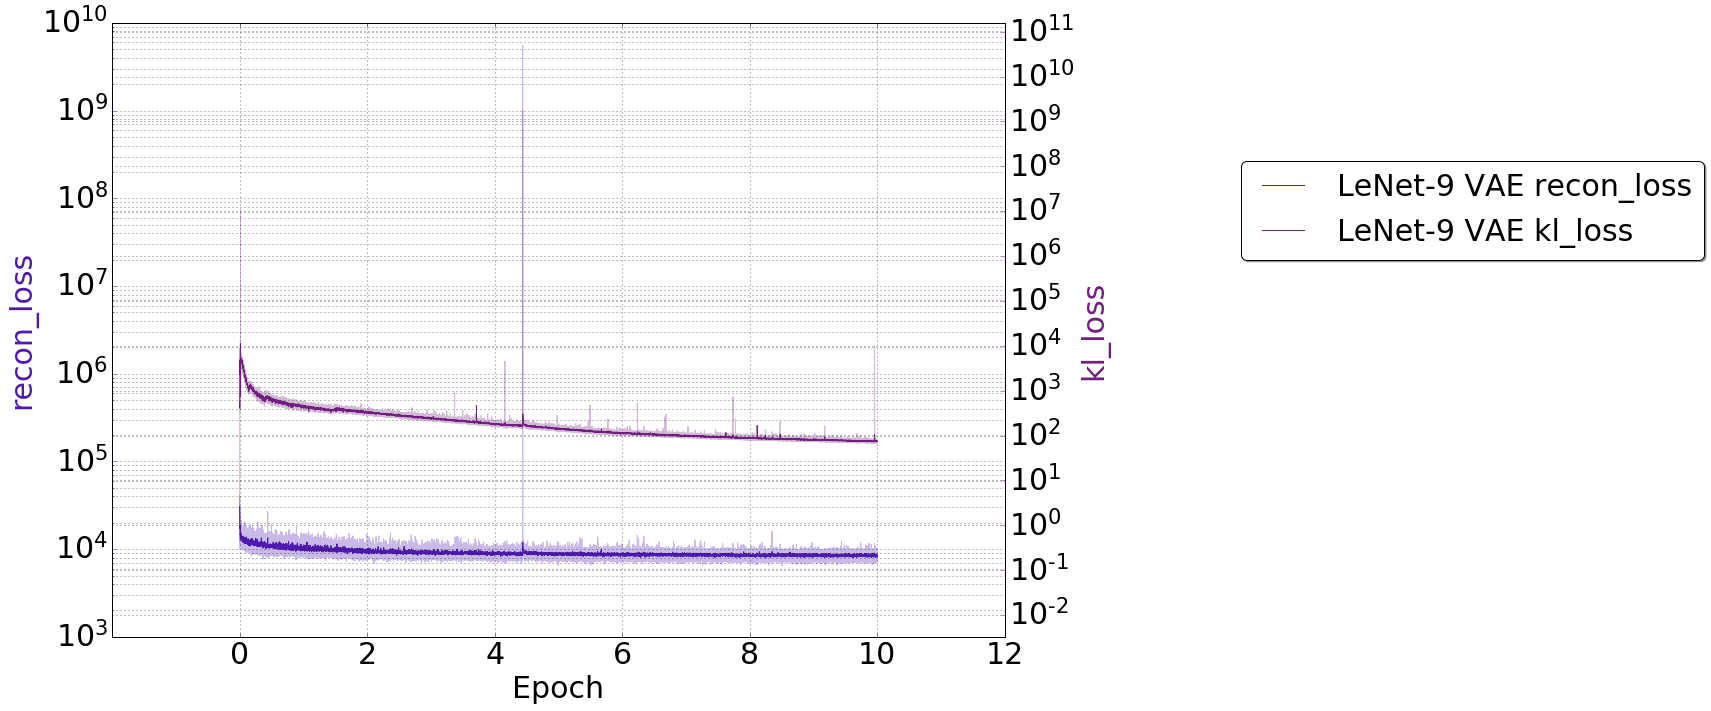

In [11]:
run_ids = ["20191022_171118"]
model_ids = ["LeNet-9 VAE"]

model_colors = [(np.random.rand(3,), np.random.rand(3,)) for model in model_ids]
keys = ["recon_loss", "kl_loss"]

plot_log(run_ids, model_ids, model_colors, keys, lgd_loc=(1.8, 0.8), val=True, log=True, show=True)

## LeNet-9 CNN trained for 10.0 epochs

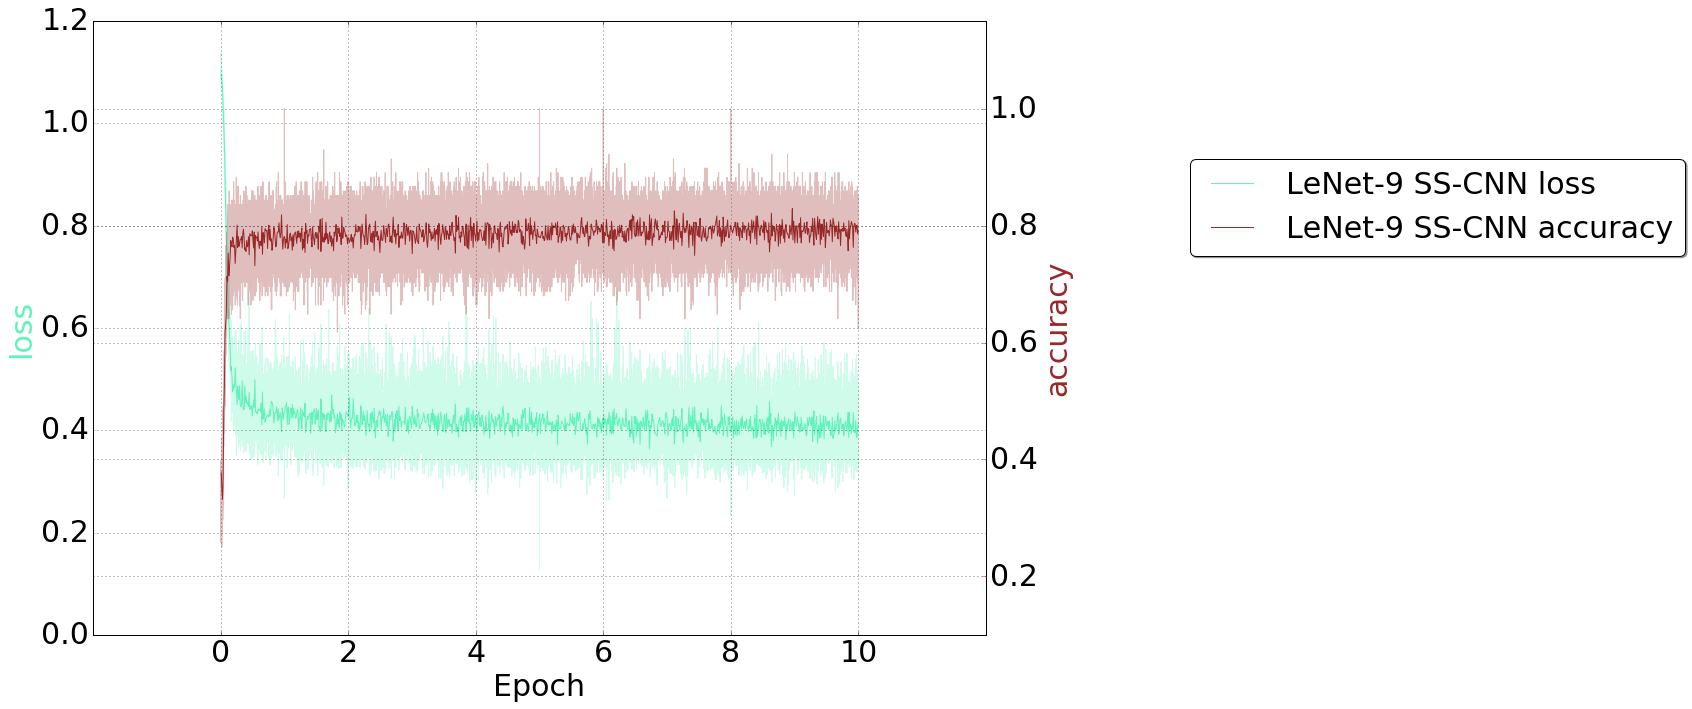

In [56]:
#run_ids = ["20191023_160523", "20191023_160610", "20191023_160635"]
#model_ids = ["LeNet-9 CNN (11250)", "LeNet-9 CNN (22500)", "LeNet-9 CNN (45000)"]

run_ids = ["20191025_143306"]
model_ids = ["LeNet-9 SS-CNN"]

model_colors = [(np.random.rand(3,), np.random.rand(3,)) for model in model_ids]
keys = ["loss", "accuracy"]

plot_log(run_ids, model_ids, model_colors, keys, lgd_loc=(1.8, 0.8), val=True, log=False, show=True)

-------------------------------------------------------------
Plotting the ROC curve for LeNet CNN trained using 720000 samples
-------------------------------------------------------------


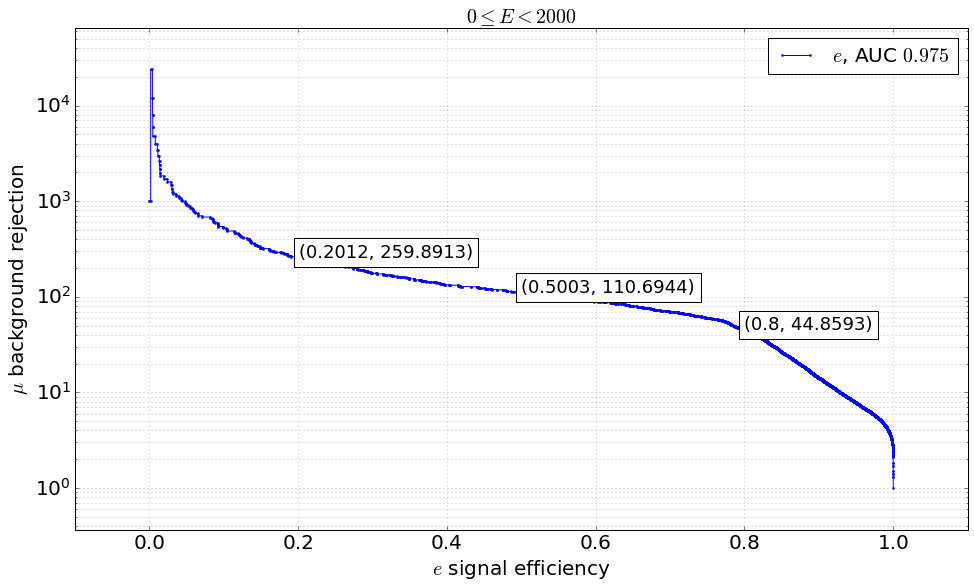

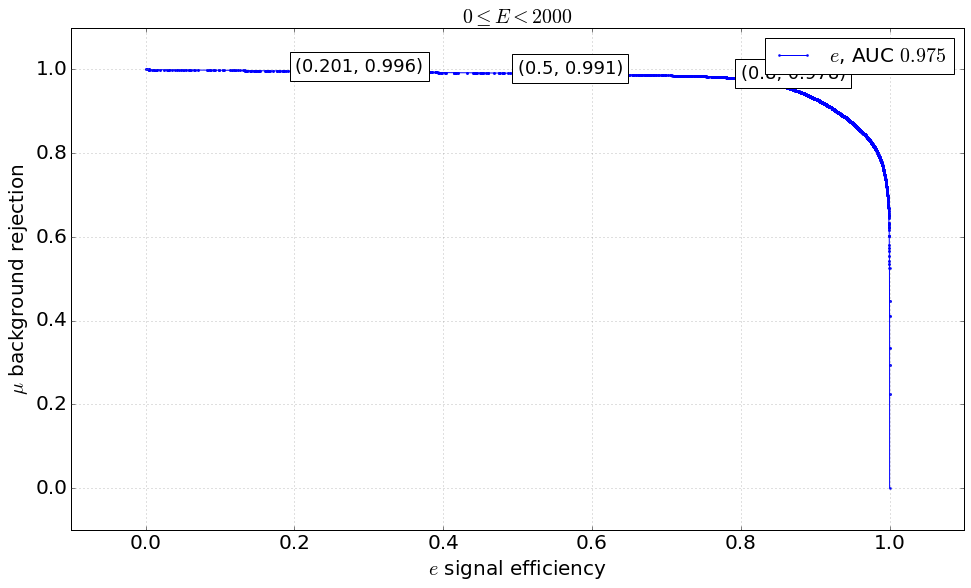

In [69]:
#num_samples = [11250, 22500, 45000]
#run_ids = ["20191023_160523", "20191023_160610", "20191023_160635"]

num_samples = [720000]
run_ids = ["20191030_060932"]

dump_dir = "/home/akajal/WatChMaL/VAE/dumps/"
dump_file = "/test_validation_iteration_dump.npz"
softmax_index_dict = {"gamma":0, "e":1, "mu":2}

for num_sample, run_id in zip(num_samples, run_ids):
    
    print("-------------------------------------------------------------")
    print("Plotting the ROC curve for LeNet CNN trained using {0} samples".format(num_sample))
    print("-------------------------------------------------------------")
    
    test_dump_path = dump_dir + run_id + dump_file
    test_dump_np = np.load(test_dump_path)
    
    test_softmax  = test_dump_np['softmax'].reshape(-1, 3)
    test_labels   = test_dump_np['labels'].reshape(-1)
    test_energies = test_dump_np['energies'].reshape(-1)
    
    roc_metrics = plot_new_ROC(test_softmax, test_labels, test_energies,
                               softmax_index_dict, "e", "mu", min_energy=0,
                               max_energy=2000, show_plot=True)
    
    roc_metrics = plot_old_ROC(test_softmax, test_labels, test_energies,
                               softmax_index_dict, "e", "mu", min_energy=0,
                               max_energy=2000, show_plot=True)

## M1 trained for 10.0 epochs

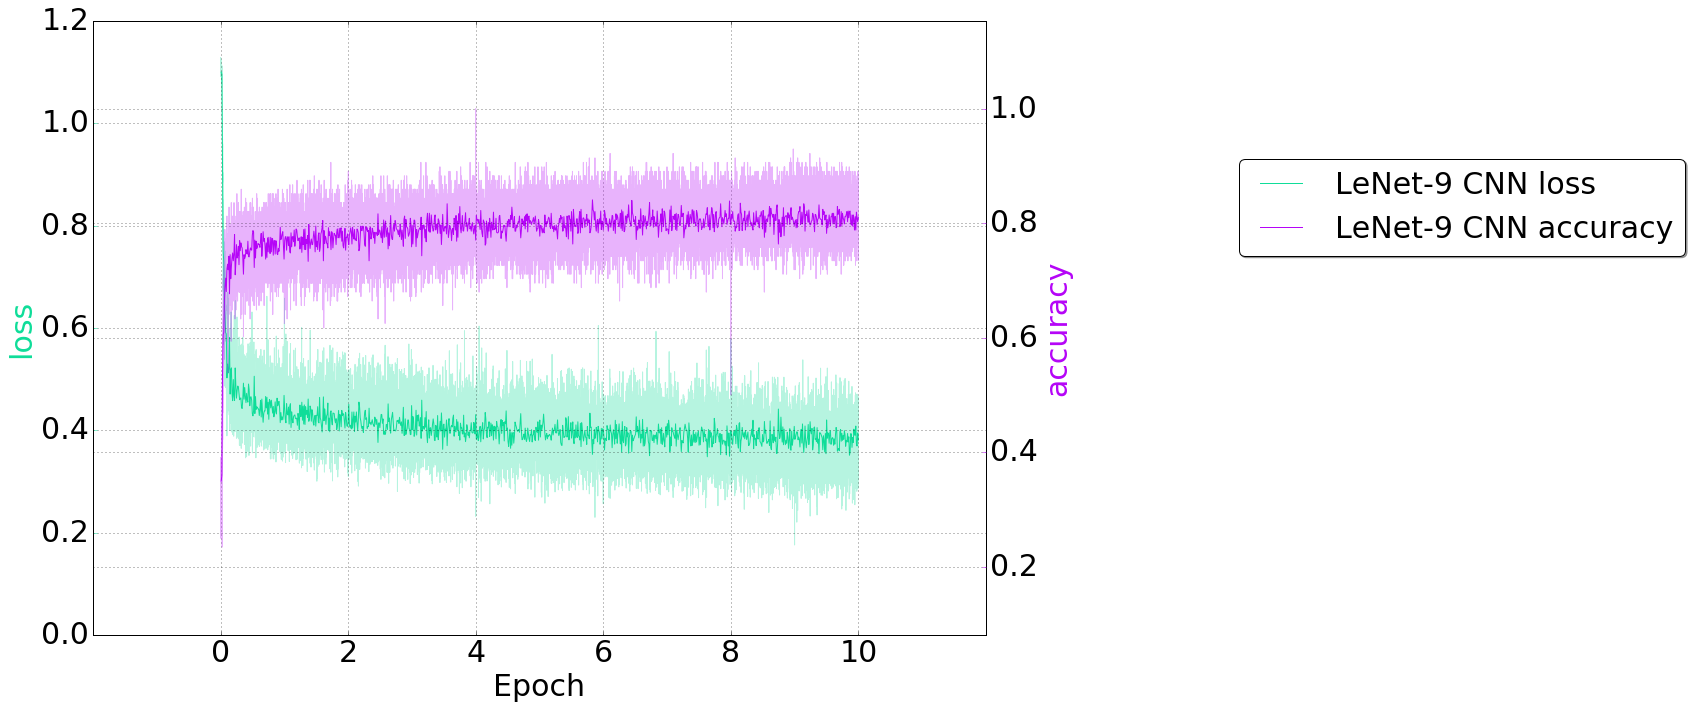

In [58]:
#run_ids = ["20191023_162310", "20191023_162602", "20191023_162950"]
#model_ids = ["LeNet-9 CNN (11250)", "LeNet-9 CNN (22500)", "LeNet-9 CNN (45000)"]

run_ids = ["20191025_143425"]
model_ids = ["LeNet-9 CNN"]

model_colors = [(np.random.rand(3,), np.random.rand(3,)) for model in model_ids]
keys = ["loss", "accuracy"]

plot_log(run_ids, model_ids, model_colors, keys, lgd_loc=(1.8, 0.8), val=True, log=False, show=True)

-------------------------------------------------------------
Plotting the ROC curve for LeNet CNN trained using 300000 samples
-------------------------------------------------------------


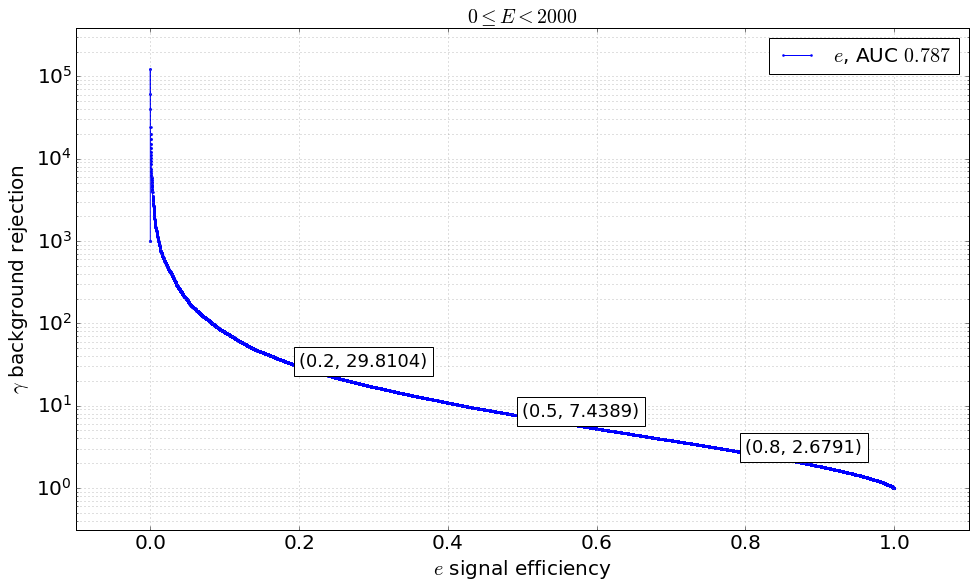

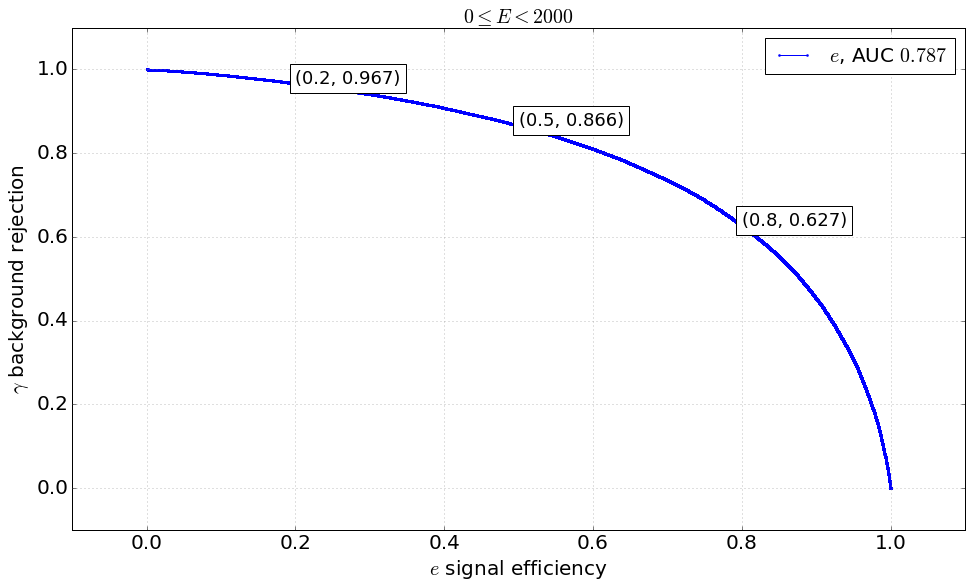

In [59]:
#num_samples = [11250, 22500, 45000]
#run_ids = ["20191023_162310", "20191023_162602", "20191023_162950"]

num_samples = [300000]
run_ids = ["20191025_143425"]

dump_dir = "/home/akajal/WatChMaL/VAE/dumps/"
dump_file = "/test_validation_iteration_dump.npz"
softmax_index_dict = {"gamma":0, "e":1, "mu":2}

for num_sample, run_id in zip(num_samples, run_ids):
    
    print("-------------------------------------------------------------")
    print("Plotting the ROC curve for LeNet CNN trained using {0} samples".format(num_sample))
    print("-------------------------------------------------------------")
    
    test_dump_path = dump_dir + run_id + dump_file
    test_dump_np = np.load(test_dump_path)
    
    test_softmax  = test_dump_np['softmax'].reshape(-1, 3)
    test_labels   = test_dump_np['labels'].reshape(-1)
    test_energies = test_dump_np['energies'].reshape(-1)
    
    roc_metrics = plot_new_ROC(test_softmax, test_labels, test_energies,
                               softmax_index_dict, "e", "gamma", min_energy=0,
                               max_energy=2000, show_plot=True)
    
    roc_metrics = plot_old_ROC(test_softmax, test_labels, test_energies,
                               softmax_index_dict, "e", "gamma", min_energy=0,
                               max_energy=2000, show_plot=True)

## M1 trained for 10.0 epochs with train_all = True

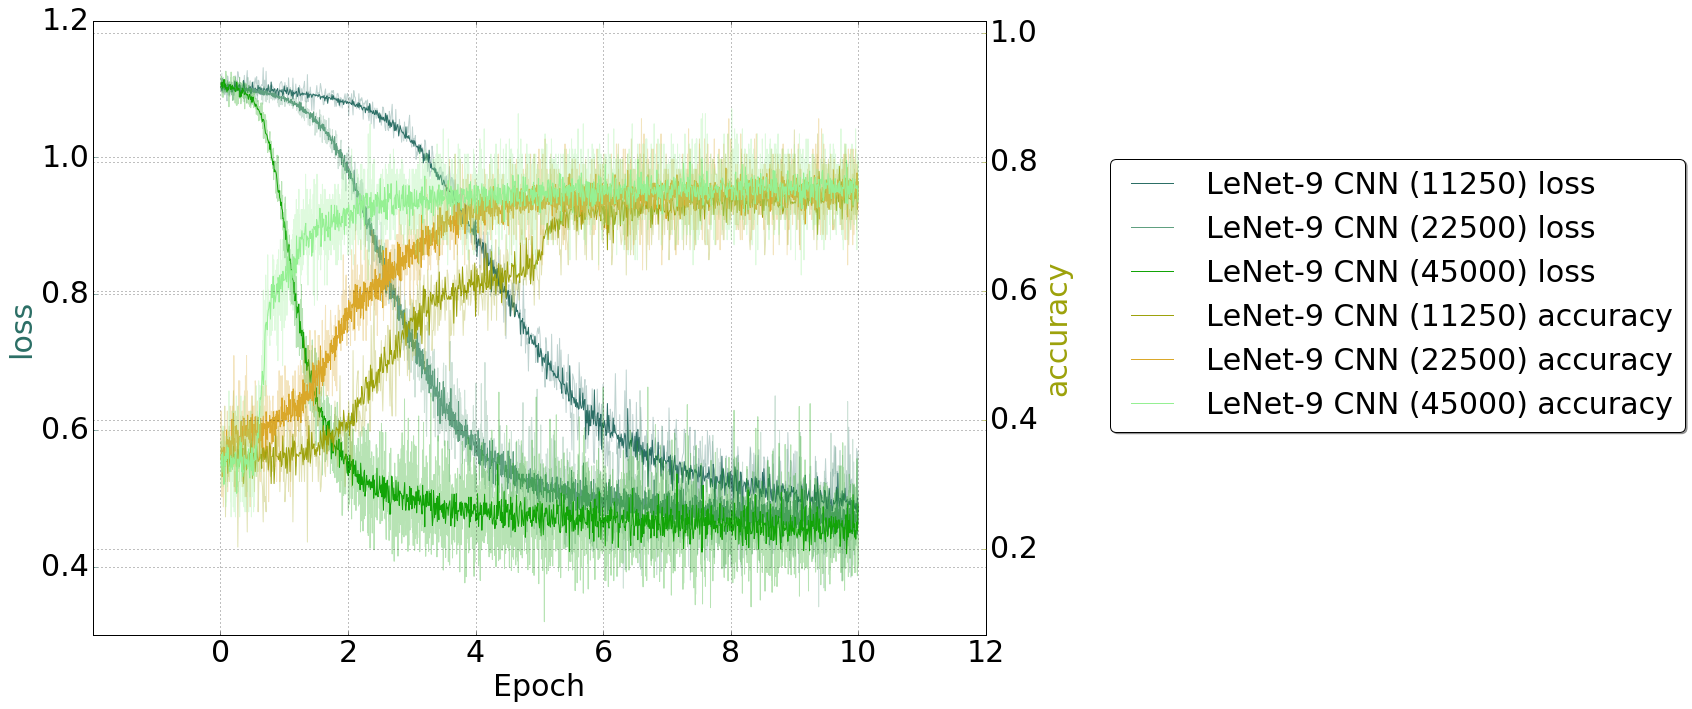

In [43]:
run_ids = ["20191023_163526", "20191023_163624", "20191023_163704"]
model_ids = ["LeNet-9 CNN (11250)", "LeNet-9 CNN (22500)", "LeNet-9 CNN (45000)"]

model_colors = [(np.random.rand(3,), np.random.rand(3,)) for model in model_ids]
keys = ["loss", "accuracy"]

plot_log(run_ids, model_ids, model_colors, keys, lgd_loc=(1.8, 0.8), val=True, log=False, show=True)

-------------------------------------------------------------
Plotting the ROC curve for LeNet CNN trained using 11250 samples
-------------------------------------------------------------


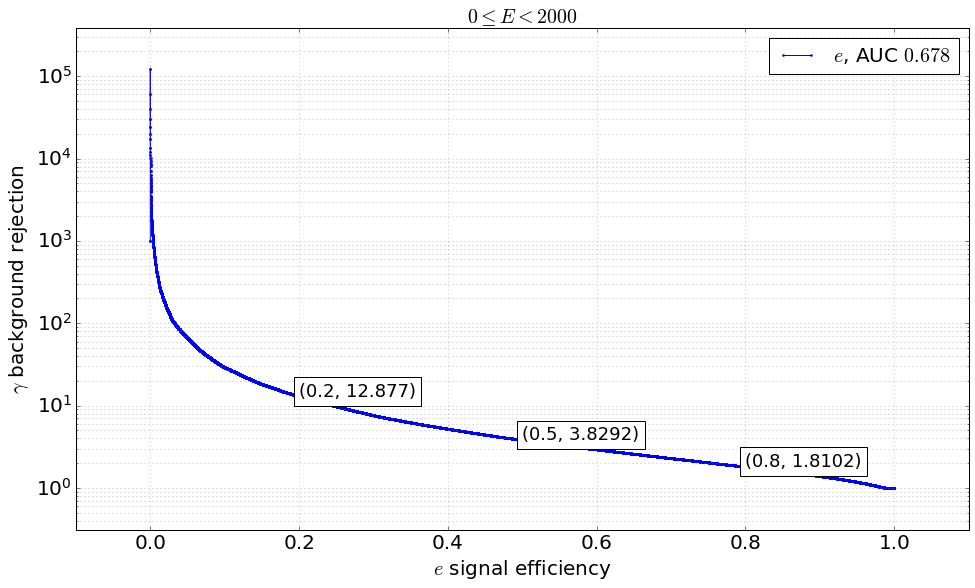

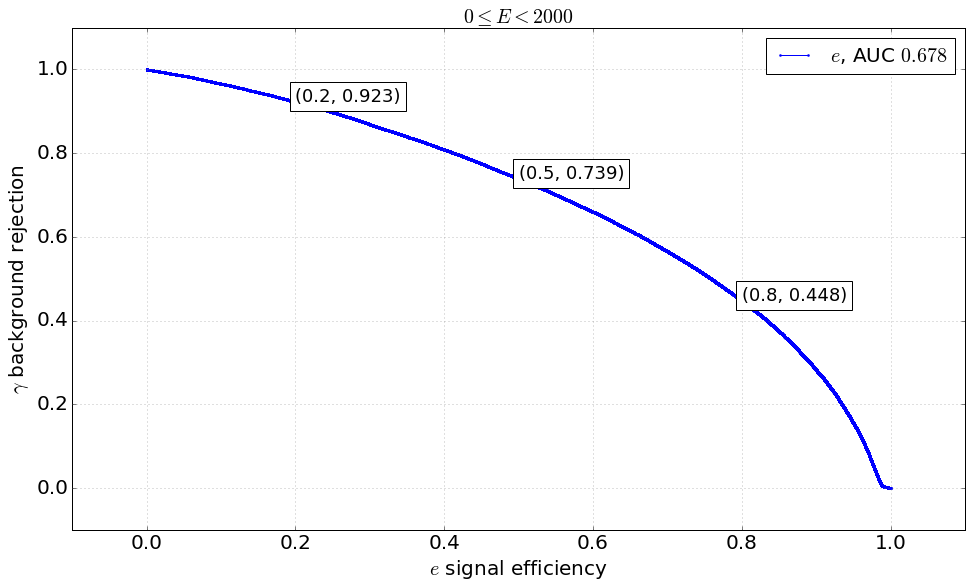

-------------------------------------------------------------
Plotting the ROC curve for LeNet CNN trained using 22500 samples
-------------------------------------------------------------


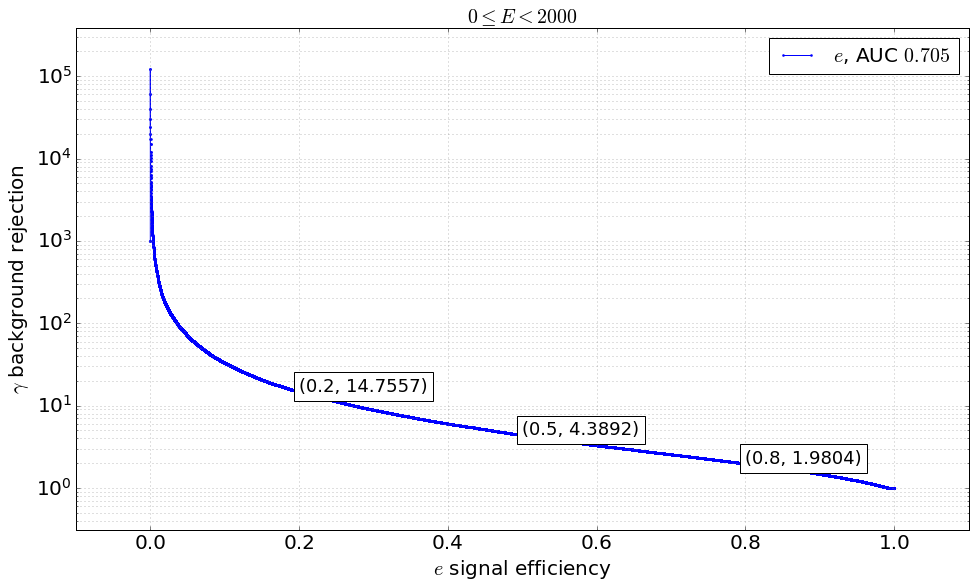

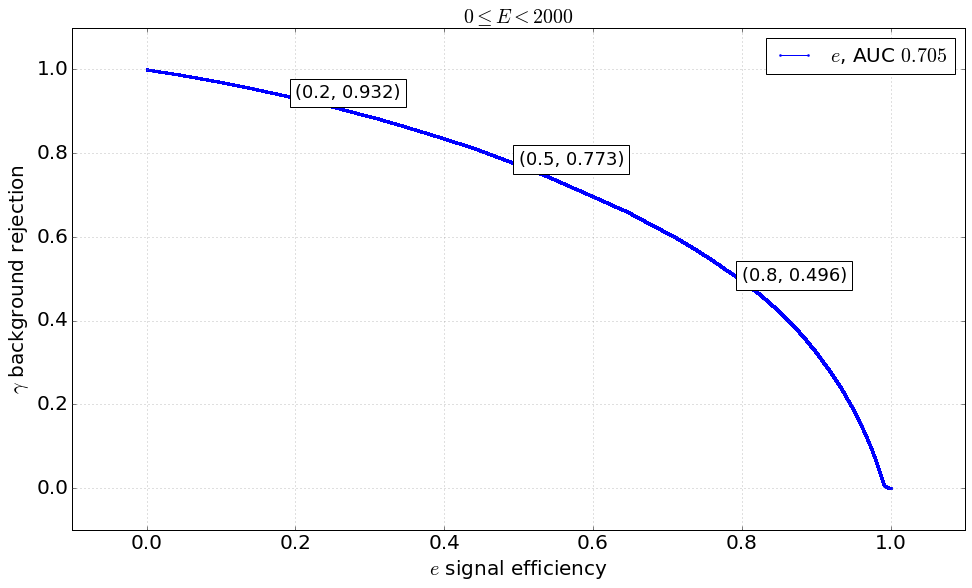

-------------------------------------------------------------
Plotting the ROC curve for LeNet CNN trained using 45000 samples
-------------------------------------------------------------


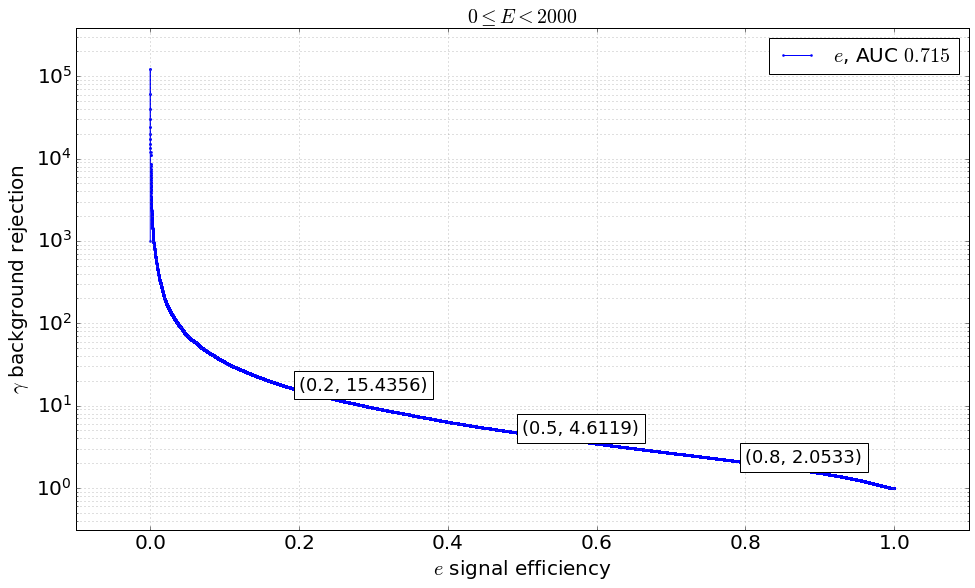

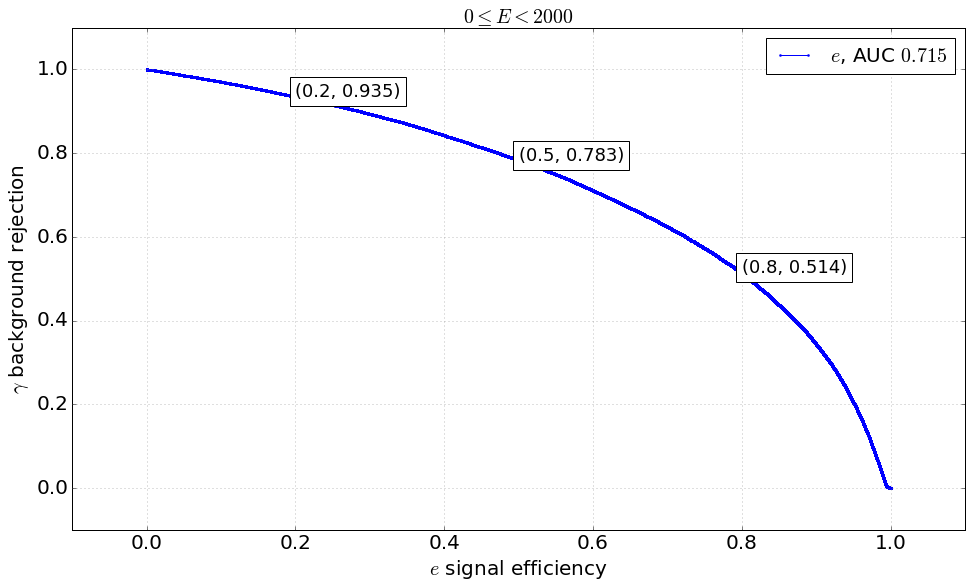

In [44]:
num_samples = [11250, 22500, 45000]
run_ids = ["20191023_163526", "20191023_163624", "20191023_163704"]

dump_dir = "/home/akajal/WatChMaL/VAE/dumps/"
dump_file = "/test_validation_iteration_dump.npz"
softmax_index_dict = {"gamma":0, "e":1, "mu":2}

for num_sample, run_id in zip(num_samples, run_ids):
    
    print("-------------------------------------------------------------")
    print("Plotting the ROC curve for LeNet CNN trained using {0} samples".format(num_sample))
    print("-------------------------------------------------------------")
    
    test_dump_path = dump_dir + run_id + dump_file
    test_dump_np = np.load(test_dump_path)
    
    test_softmax  = test_dump_np['softmax'].reshape(-1, 3)
    test_labels   = test_dump_np['labels'].reshape(-1)
    test_energies = test_dump_np['energies'].reshape(-1)
    
    roc_metrics = plot_new_ROC(test_softmax, test_labels, test_energies,
                               softmax_index_dict, "e", "gamma", min_energy=0,
                               max_energy=2000, show_plot=True)
    
    roc_metrics = plot_old_ROC(test_softmax, test_labels, test_energies,
                               softmax_index_dict, "e", "gamma", min_energy=0,
                               max_energy=2000, show_plot=True)

## M1 without reparameterization trained for 10.0 epochs

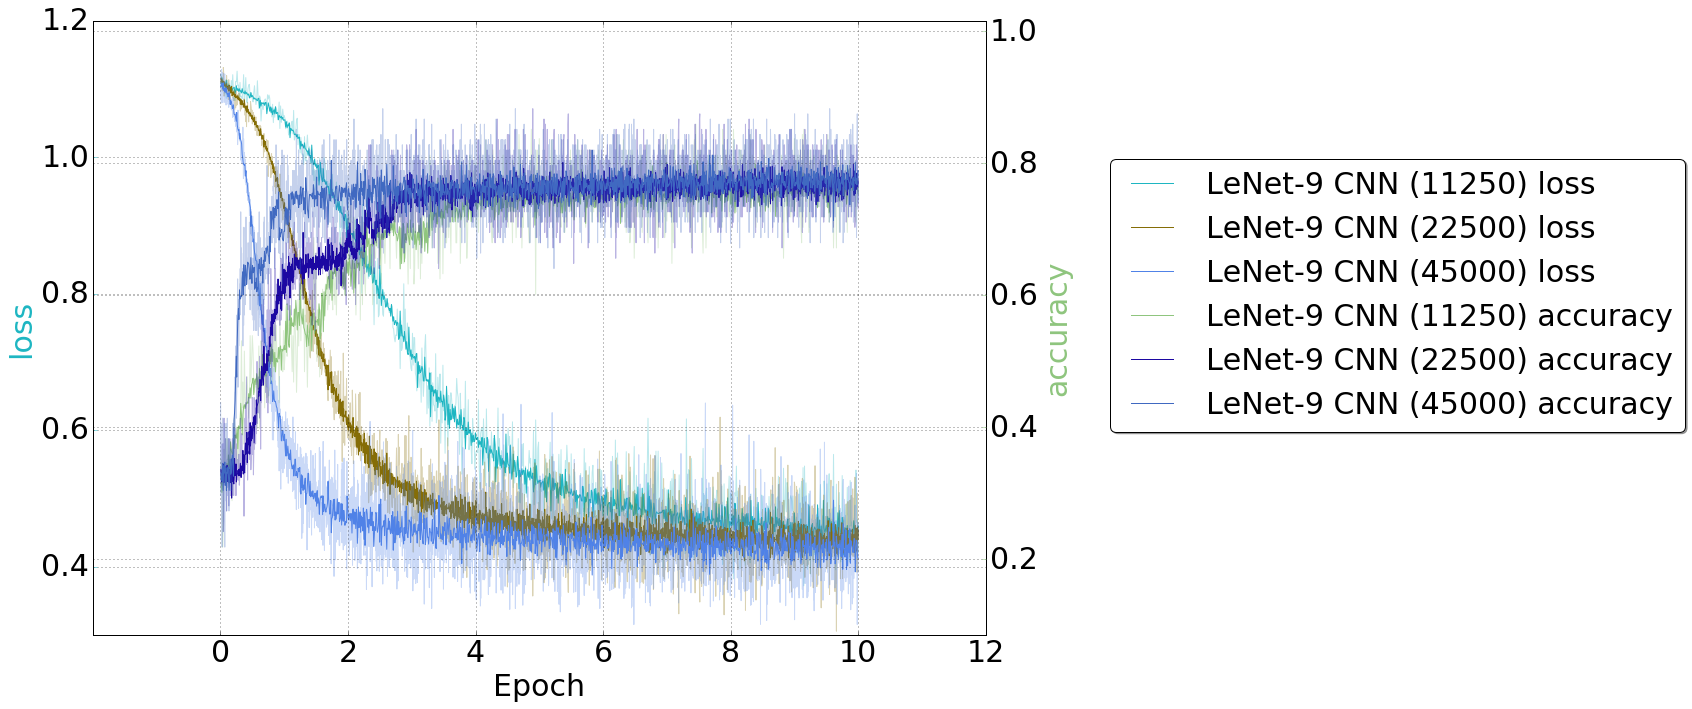

In [25]:
run_ids = ["20191023_152132", "20191023_152241", "20191023_152319"]
model_ids = ["LeNet-9 CNN (11250)", "LeNet-9 CNN (22500)", "LeNet-9 CNN (45000)"]

model_colors = [(np.random.rand(3,), np.random.rand(3,)) for model in model_ids]
keys = ["loss", "accuracy"]

plot_log(run_ids, model_ids, model_colors, keys, lgd_loc=(1.8, 0.8), val=True, log=False, show=True)

-------------------------------------------------------------
Plotting the ROC curve for LeNet CNN trained using 11250 samples
-------------------------------------------------------------


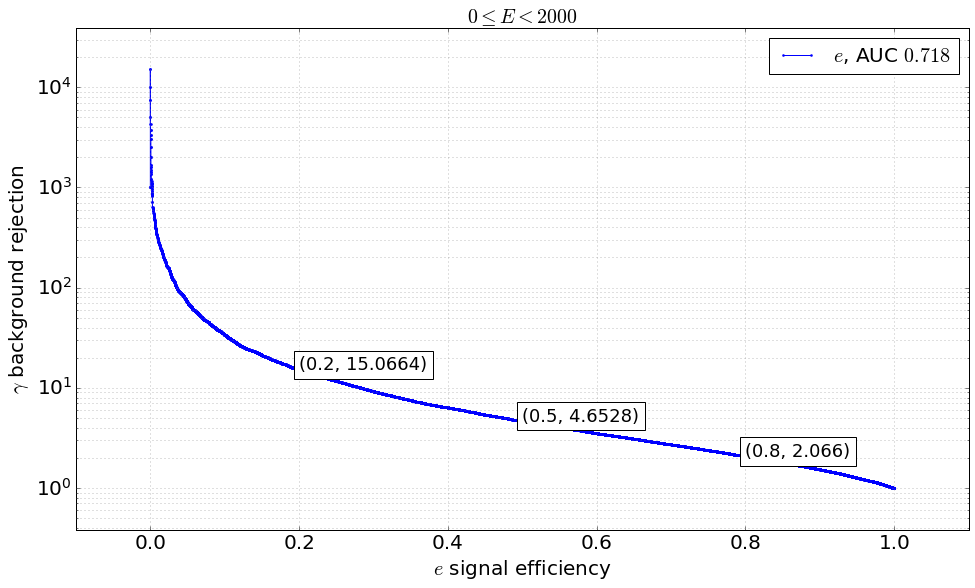

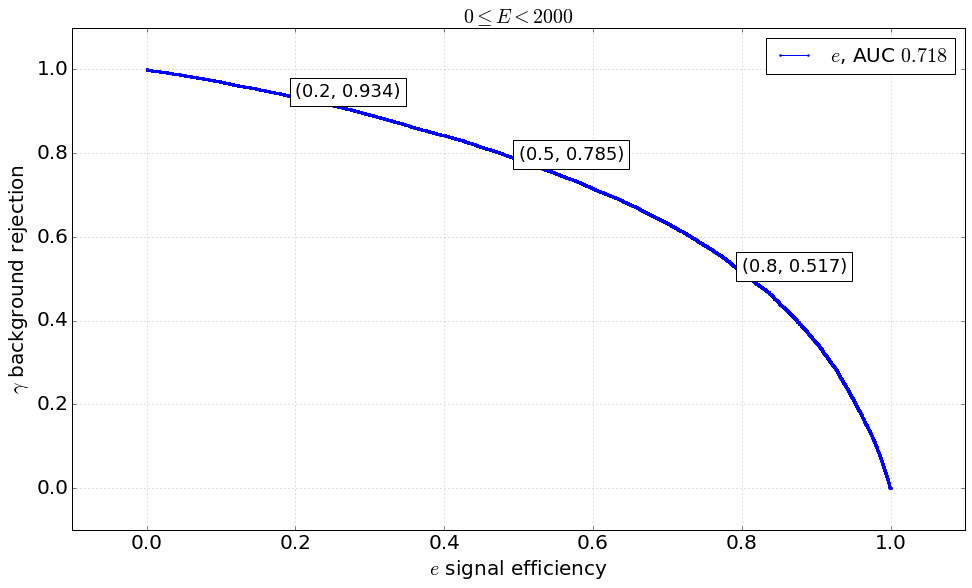

-------------------------------------------------------------
Plotting the ROC curve for LeNet CNN trained using 22500 samples
-------------------------------------------------------------


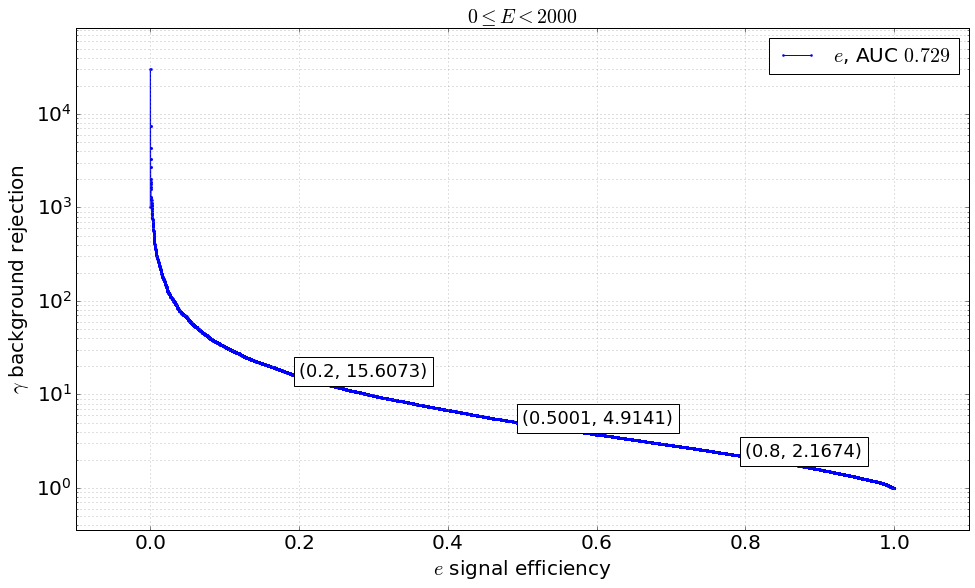

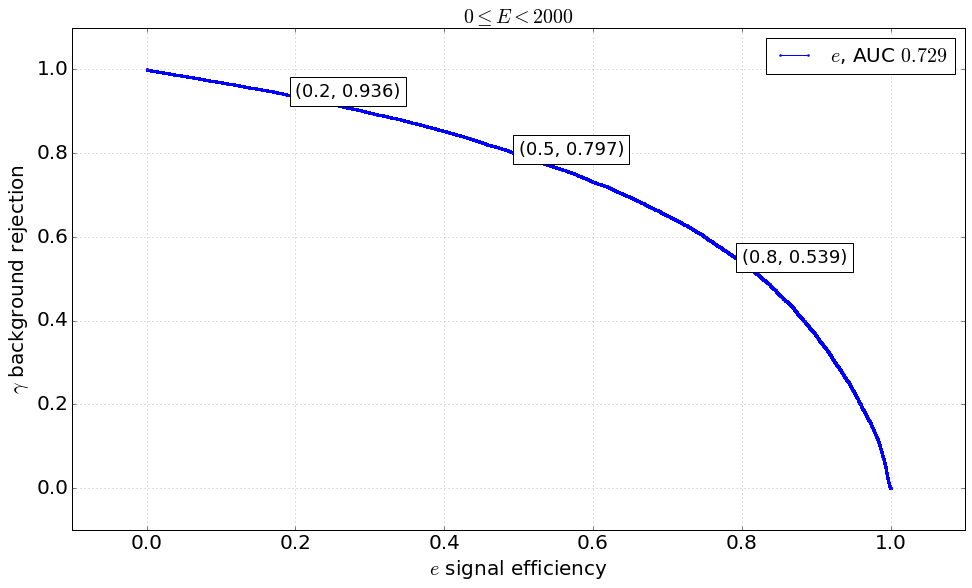

-------------------------------------------------------------
Plotting the ROC curve for LeNet CNN trained using 45000 samples
-------------------------------------------------------------


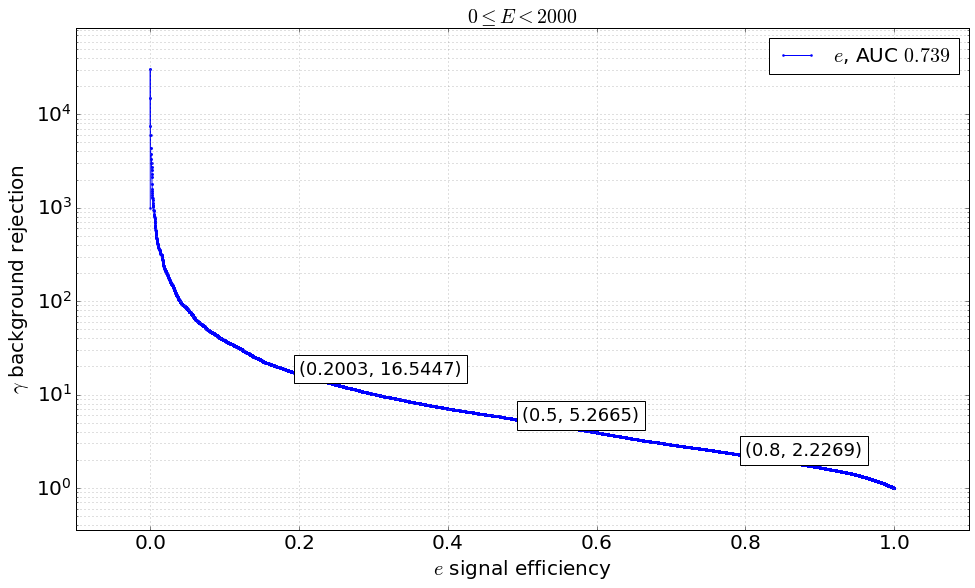

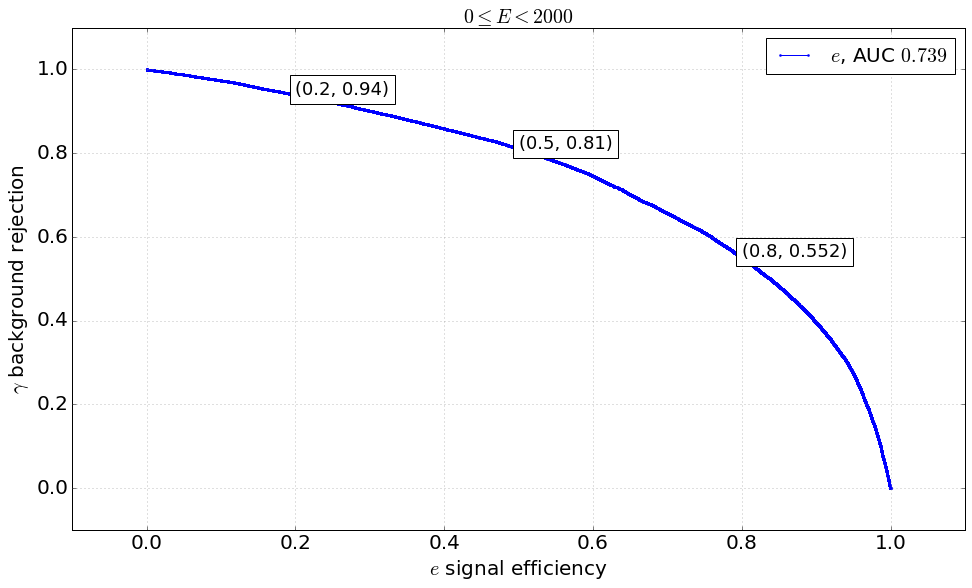

In [26]:
num_samples = [11250, 22500, 45000]
run_ids = ["20191023_152132", "20191023_152241", "20191023_152319"]

dump_dir = "/home/akajal/WatChMaL/VAE/dumps/"
dump_file = "/test_validation_iteration_dump.npz"
softmax_index_dict = {"gamma":0, "e":1, "mu":2}

for num_sample, run_id in zip(num_samples, run_ids):
    
    print("-------------------------------------------------------------")
    print("Plotting the ROC curve for LeNet CNN trained using {0} samples".format(num_sample))
    print("-------------------------------------------------------------")
    
    test_dump_path = dump_dir + run_id + dump_file
    test_dump_np = np.load(test_dump_path)
    
    test_softmax  = test_dump_np['softmax'].reshape(-1, 3)
    test_labels   = test_dump_np['labels'].reshape(-1)
    test_energies = test_dump_np['energies'].reshape(-1)
    
    roc_metrics = plot_new_ROC(test_softmax, test_labels, test_energies,
                               softmax_index_dict, "e", "gamma", min_energy=0,
                               max_energy=2000, show_plot=True)
    
    roc_metrics = plot_old_ROC(test_softmax, test_labels, test_energies,
                               softmax_index_dict, "e", "gamma", min_energy=0,
                               max_energy=2000, show_plot=True)

## M1 without reparameterization trained for 10.0 epochs with train_all = False

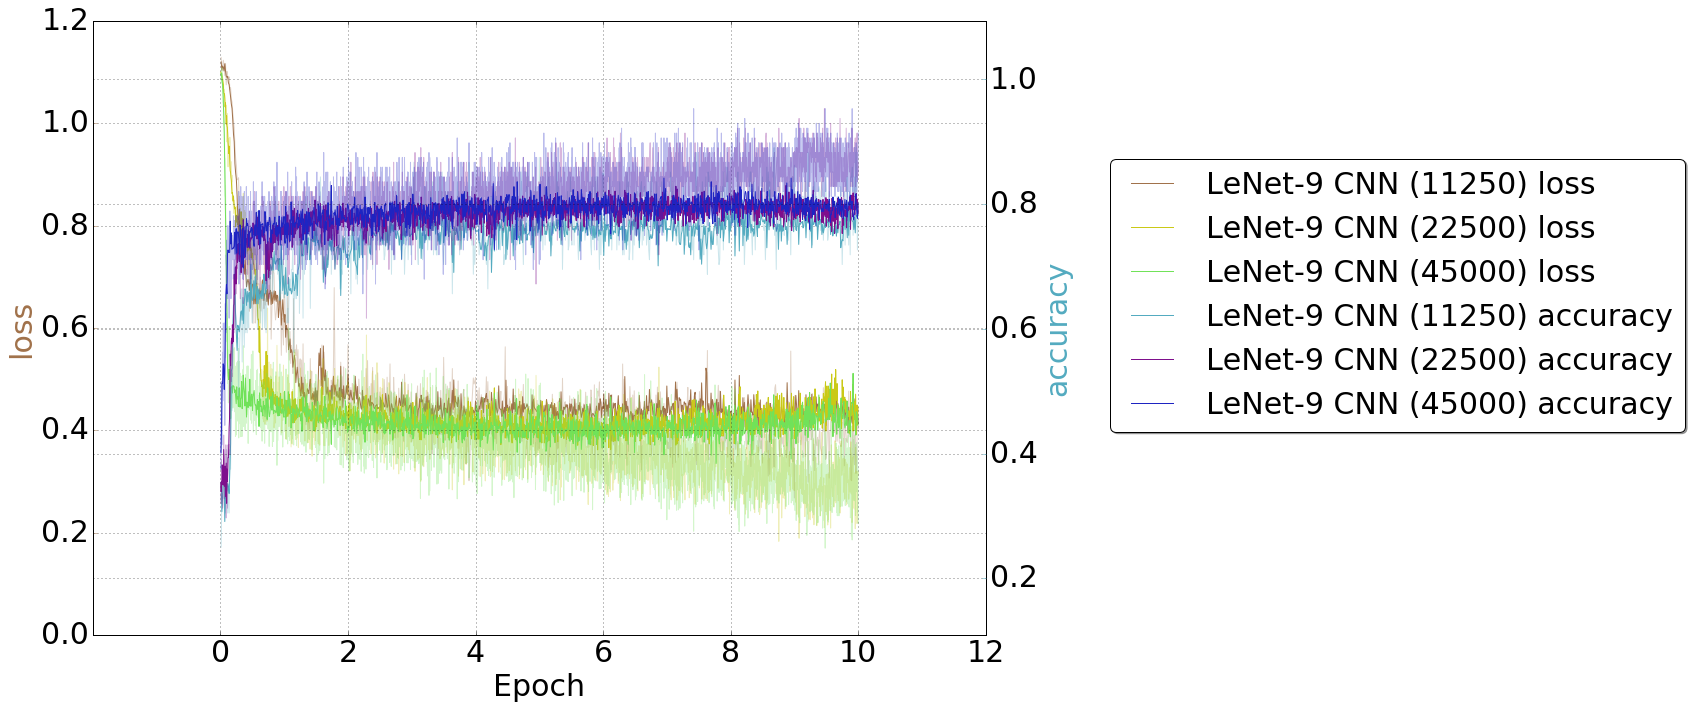

In [49]:
run_ids = ["20191023_164350", "20191023_164642", "20191023_170218"]
model_ids = ["LeNet-9 CNN (11250)", "LeNet-9 CNN (22500)", "LeNet-9 CNN (45000)"]

model_colors = [(np.random.rand(3,), np.random.rand(3,)) for model in model_ids]
keys = ["loss", "accuracy"]

plot_log(run_ids, model_ids, model_colors, keys, lgd_loc=(1.8, 0.8), val=True, log=False, show=True)

-------------------------------------------------------------
Plotting the ROC curve for LeNet CNN trained using 11250 samples
-------------------------------------------------------------


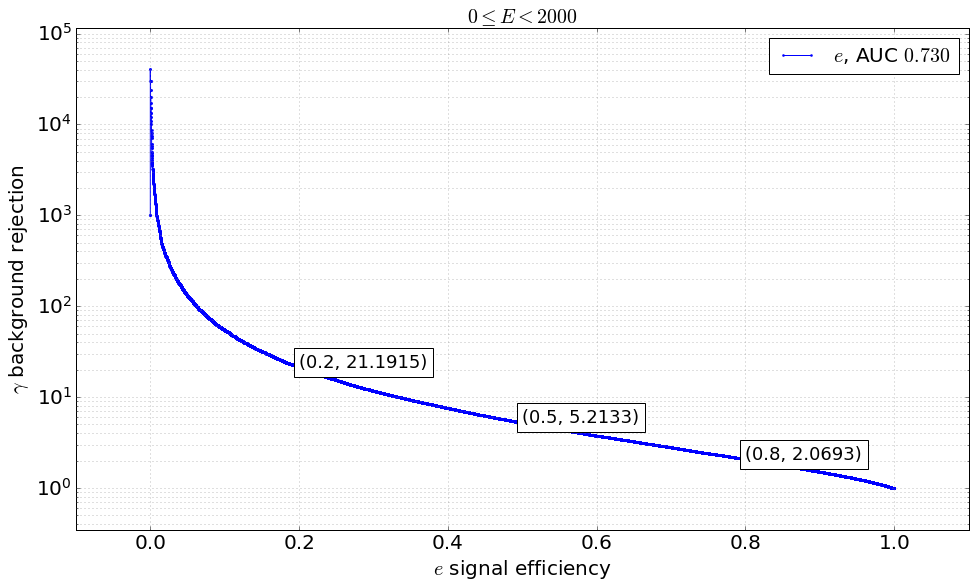

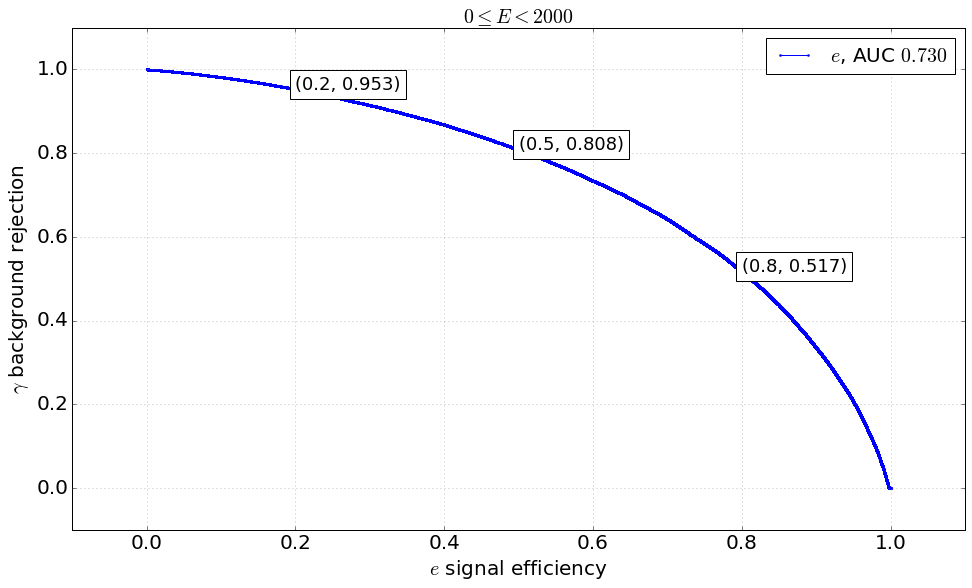

-------------------------------------------------------------
Plotting the ROC curve for LeNet CNN trained using 22500 samples
-------------------------------------------------------------


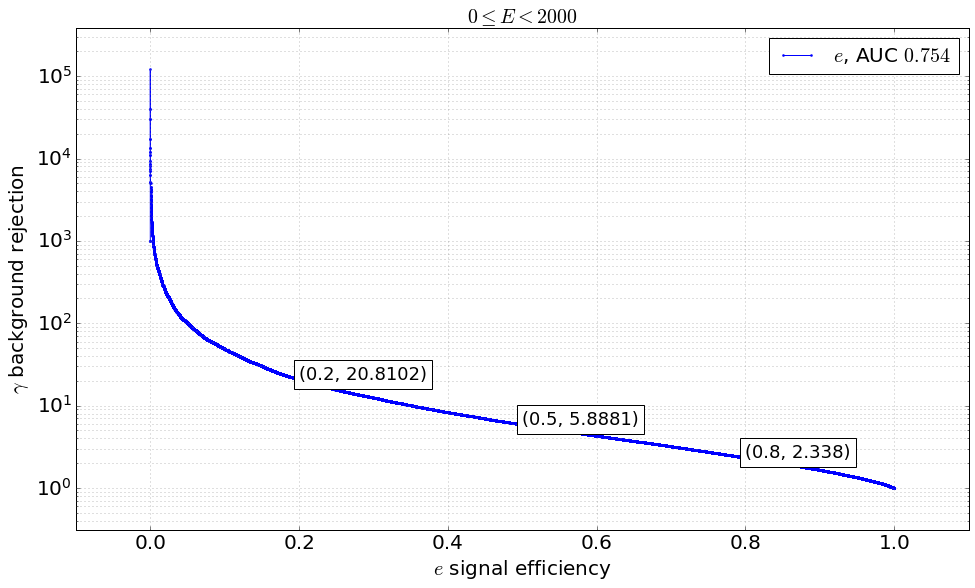

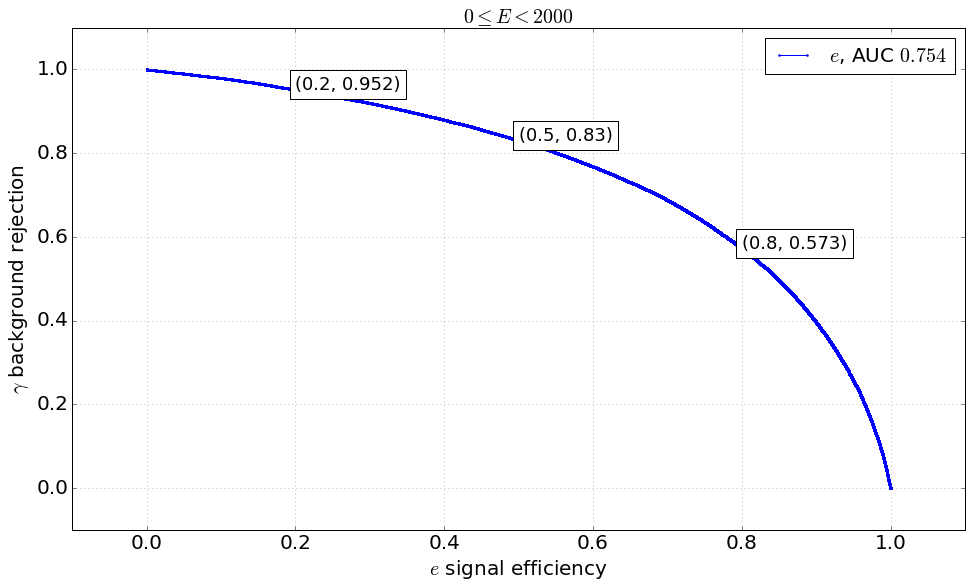

-------------------------------------------------------------
Plotting the ROC curve for LeNet CNN trained using 45000 samples
-------------------------------------------------------------


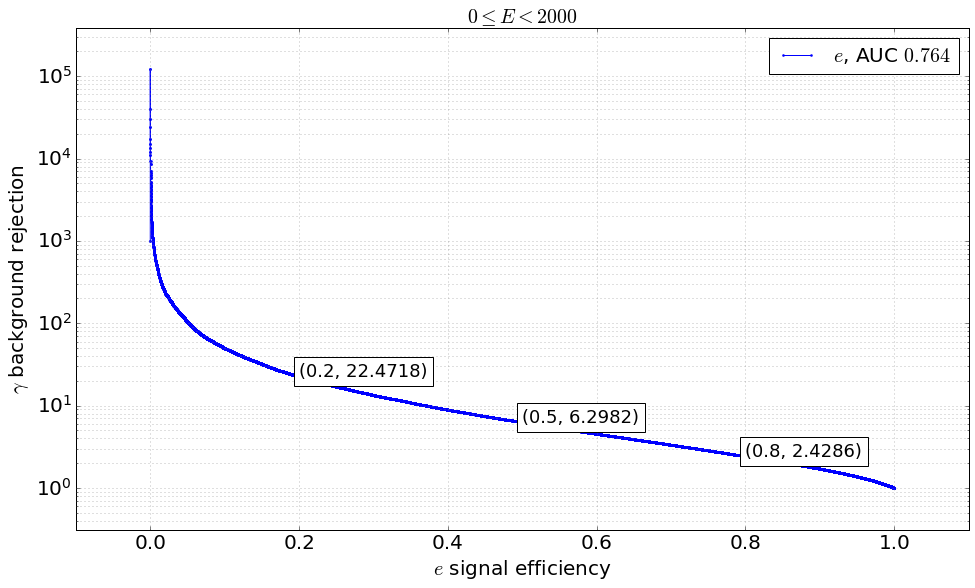

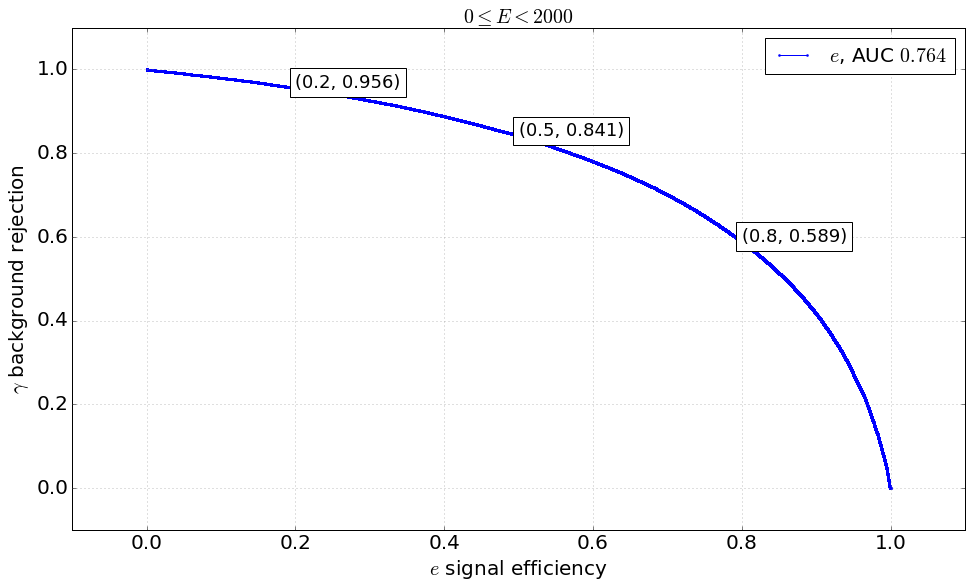

In [50]:
num_samples = [11250, 22500, 45000]
run_ids = ["20191023_164350", "20191023_164642", "20191023_170218"]

dump_dir = "/home/akajal/WatChMaL/VAE/dumps/"
dump_file = "/test_validation_iteration_dump.npz"
softmax_index_dict = {"gamma":0, "e":1, "mu":2}

for num_sample, run_id in zip(num_samples, run_ids):
    
    print("-------------------------------------------------------------")
    print("Plotting the ROC curve for LeNet CNN trained using {0} samples".format(num_sample))
    print("-------------------------------------------------------------")
    
    test_dump_path = dump_dir + run_id + dump_file
    test_dump_np = np.load(test_dump_path)
    
    test_softmax  = test_dump_np['softmax'].reshape(-1, 3)
    test_labels   = test_dump_np['labels'].reshape(-1)
    test_energies = test_dump_np['energies'].reshape(-1)
    
    roc_metrics = plot_new_ROC(test_softmax, test_labels, test_energies,
                               softmax_index_dict, "e", "gamma", min_energy=0,
                               max_energy=2000, show_plot=True)
    
    roc_metrics = plot_old_ROC(test_softmax, test_labels, test_energies,
                               softmax_index_dict, "e", "gamma", min_energy=0,
                               max_energy=2000, show_plot=True)